In [1]:
import utils
from utils import *
# from resnet50 import *
from keras.applications.resnet50 import *
from keras.preprocessing import image
from keras.preprocessing.image import *

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from ImageDataGenerator_extended2 import *
from image_90rotations import *

from sklearn.utils import class_weight


%matplotlib inline
from sys import getsizeof
import seaborn as sns

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)


In [2]:
target_size = (224,224)#(256, 256)

In [3]:
K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

### Load Data

In [4]:
x_train = []
y_train = []

df_train = pd.read_csv('data/train_v2.csv')
df_test = pd.read_csv('data/sample_submission_v2.csv')


labels = ['blow_down',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'cultivation',
 'artisinal_mine',
 'haze',
 'primary',
 'slash_burn',
 'habitation',
 'clear',
 'road',
 'selective_logging',
 'partly_cloudy',
 'agriculture',
 'water',
 'cloudy']

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

### Load JPEG files

In [5]:
# y_train = []
# x_train = np.zeros((df_train.shape[0],3,target_size[0],target_size[0])).astype(np.float32)

# for f, tags in tqdm_notebook(df_train.values, miniters=1000):
#     targets = np.zeros(17)
    
#     for t in tags.split(' '):
#         targets[label_map[t]] = 1 
        

#     y_train.append(targets)

# c = 0

# loading images the keras way
# for f, tags in tqdm_notebook(df_train.values, miniters=1000):
    
#     img = image.load_img('data/train-jpg/{}.jpg'.format(f), target_size=target_size)
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     x_train[c] = x
#     c +=1
        
#     x_train.append(x)
    



In [6]:
# plt.imshow(x_train[0][0].transpose(1,2,0))

In [7]:
# x_test = []

# for f, tags in tqdm(df_test.values, miniters=1000):
#     img = cv2.imread('data/test-jpg/{}.jpg'.format(f))
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   

#     x_test.append(cv2.resize(img, target_size))


# x_test  = np.array(x_test, np.float32) #/ 255.
# x_test = x_test.transpose((0, 3, 1, 2))

In [8]:
# y_train = np.array(y_train, np.uint8)
# x_train = np.array(x_train, np.float32) #/ 255.

#Transpose the data if using Theano

# x_train = x_train.transpose((0, 3, 1, 2))

# x_test  = np.array(x_test, np.float32) #/ 255.
# x_test = x_test.transpose((0, 3, 1, 2))






In [9]:
# save_array("data/cache/xtrain_100x100.dat",x_train)
# save_array("data/cache/xtest_100x100.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# save_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[0]),x_train)
# save_array("data/cache/xtest_{}x{}.dat".format(target_size[0],target_size[0]),x_test)


In [5]:
x_train = load_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[1]))
y_train = load_array("data/cache/ytrain_original.dat")



In [6]:
y_train = y_train[:,label_map["cloudy"]]

In [7]:
new_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


In [8]:
new_class_weights

array([ 0.5272,  9.6886])

#### Loading test  data

In [13]:
x_test = np.memmap("data/cache/xtest_{}x{}.memmapped".format(target_size[0],target_size[0]), dtype='float32', mode='w+', 
                       shape=(df_test.shape[0],3,target_size[0],target_size[0]))

In [14]:
### Test data
# c = 0
# for f, tags in tqdm_notebook(df_test.values, miniters=1000):
    
#     img = image.load_img('data/test-jpg/{}.jpg'.format(f), target_size=target_size)
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     x_test[c] = x
#     c +=1
        


### Model Training 


In [9]:
input_tensor = Input(shape=(3,224, 224))
resnet = ResNet50(include_top=False, input_tensor=input_tensor,classes=17)
# resnet = ResNet50(include_top=True, classes=17)

In [10]:
for layer in resnet.layers:
    layer.trainable = False

In [11]:
resnet.layers[-138].name

'activation_10'

In [9]:
for i in range(-33,0):
    # 3a: -138
    # 4a: -95
    # tuning 5b: -21
    # tuning branch 5c -11
    # tuning from 5a: -33
    resnet.layers[i].trainable = True

In [18]:
# img = image.load_img('data/train-jpg/{}.jpg'.format("train_9"), target_size=target_size)
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# x = np.append(x,x,axis=0)


In [11]:
x = Flatten()(resnet.layers[-1].output)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)

# x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(4,activation='softmax',name="fc17")(x)
# x = Dense(4,activation='softmax',name="weatherx4")(x)



In [12]:
model = Model(inputs=resnet.input,outputs=x)
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights("weights/resnet_simpleaug_weather_5a_cont_overfitmodel.h5")

# was resnet_17class_4a_fullrotation
#resnet_simpleaug_weather_5a_cont_overfitmodel


In [26]:
model.layers[-2].name

'dropout_2'

In [12]:
del x_train

In [13]:
# x2 = model.layers[-2].output
x2 = Dense(1,activation='sigmoid',name="cloudy")(x)

model2 = Model(inputs=resnet.input,outputs=x2)
model2.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("weights/resnet_simpleaug_cloudy_toponly_alltrain.h5")



In [41]:
# model.summary()

In [16]:
for l in model2.layers:
    if l.trainable==True:
        print l.name

flatten_2
dropout_3
dense_2
dropout_4
cloudy


#### separate model output into 2 parts to differentiate between weather and other classes

In [14]:
# x2 = model.layers[-2].output #dropout layer
# weather_output = Dense(4,activation='softmax',name="weather")(x)
# rare_class_output = Dense(13,activation='sigmoid',name="rareclass")(x)

In [15]:
# modelv2 = Model (inputs=resnet.input,outputs=[weather_output,rare_class_output])
# modelv2.compile(optimizer=Adam(lr=1e-4), loss=['categorical_crossentropy','binary_crossentropy'], metrics=['accuracy'])
# modelv2.load_weights("weights/resnet_2xoutput_2x_aug_toponlyp_withaug_2x512_finetuning_5b.h5")

### Quick training and prediction (on SAMPLE data)

In [13]:
VALIDATION_SPLIT = 0.2
np.random.seed(2089)

# perm = np.random.permutation(len(x_sample))
# idx_train = perm[:int(len(x_sample)*(1-VALIDATION_SPLIT))]
# idx_val = perm[int(len(x_sample)*(1-VALIDATION_SPLIT)):]

# X_train = x_sample[idx_train]
# Y_train = y_sample[idx_train]
# X_valid = x_sample[idx_val]
# Y_valid = y_sample[idx_val]



perm = np.random.permutation(len(y_train))
idx_train = perm[:int(len(y_train)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(y_train)*(1-VALIDATION_SPLIT)):]


X_train = x_train[idx_train]
Y_train = y_train[idx_train]
X_valid = x_train[idx_val]
Y_valid = y_train[idx_val]

del x_train

In [48]:
Y_valid[0],Y_valid[10],Y_valid[2000]


(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [14]:
valid_weights = np.ones(Y_valid.shape)

In [15]:
new_class_weights

array([ 0.5272,  9.6886])

In [16]:
valid_weights[np.where(Y_valid==1)] = new_class_weights[1]

In [17]:
valid_weights[np.where(Y_valid!=1)] = new_class_weights[0]

#### With Augmentation

In [14]:
batch_size = 128


train_gen = ImageDataGenerator2(rotation_range=360,
#     width_shift_range=0.1,
#     height_shift_range=0.0,
    shear_range=0.1,
#     zoom_range=0.05,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


# train_gen = ImageDataGenerator(rotation_range=360,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     channel_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,fill_mode='reflect')



# train_batch = train_gen.flow(x_train,y_train,batch_size=batch_size,shuffle=True)


--- 


In [25]:

kfold_weights_path = os.path.join('weights/', 'resnet_simpleaug_cloudy_toponly_alltrain.h5')


#              ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-7)
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',  patience=2, verbose=1, factor=0.5, min_lr=1e-7)
            ]



#### Results


#### weather only 

resnet_simpleaug_weather_toponly.h5

252/252 [==============================] - 387s - loss: 0.2720 - acc: 0.9018 - val_loss: 0.2105 - val_acc: 0.9203


resnet_simpleaug_weather_5a_cont_overfitmodel:


Epoch 11/100
404/404 [==============================] - 529s - loss: 0.1818 - acc: 0.9319 - val_loss: 0.1770 - val_acc: 0.9318



full train set:

Epoch 2/2
505/505 [==============================] - 635s - loss: 0.1820 - acc: 0.9320 - val_loss: 0.1694 - val_acc: 0.9333



##### cloudy 

Epoch 8/100
252/252 [==============================] - 392s - loss: 0.1317 - acc: 0.9589 - val_loss: 0.0959 - val_acc: 0.9520


top only p2 
Epoch 12/100
252/252 [==============================] - 399s - loss: 0.0830 - acc: 0.9606 - val_loss: 0.0777 - val_acc: 0.9575

top only p3 (1e-5)
Epoch 3/100
252/252 [==============================] - 404s - loss: 0.0766 - acc: 0.9636 - val_loss: 0.0771 - val_acc: 0.9587



###### from scracthc (redo1.h5)

252/252 [==============================] - 388s - loss: 0.2760 - acc: 0.8994 - val_loss: 0.2355 - val_acc: 0.9144





In [32]:
history = model2.fit_generator(train_batch, validation_data=(X_valid, Y_valid,valid_weights),
                               steps_per_epoch=len(x_train)/(batch_size),epochs=2,callbacks=callbacks,
                              class_weight={0:new_class_weights[0],1:new_class_weights[1]})



Epoch 1/2
316/316 [==============================] - 482s - loss: 0.0786 - acc: 0.9644 - val_loss: 0.0767 - val_acc: 0.9600
Epoch 2/2
316/316 [==============================] - 482s - loss: 0.0825 - acc: 0.9635 - val_loss: 0.0771 - val_acc: 0.9591


#### verifying results

In [33]:
if os.path.isfile(kfold_weights_path):
    print "loading best weights from '{}'".format(kfold_weights_path)
    model2.load_weights(kfold_weights_path)
    
    

loading best weights from 'weights/resnet_simpleaug_cloudy_toponly_alltrain.h5'


In [21]:
def optimise_f2_thresholds2(y, p, verbose=True, resolution=100,num_classes=17):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(num_classes):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.1]*num_classes
    for i in range(num_classes):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            threshold = float(i2) / resolution
            x[i] = threshold
            score = mf(x)
            if score > best_score:
                best_i2 = threshold
                best_score = score

        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x


In [17]:
def make_augmented_predictions(model,data,generator,num_aug,ouput_shape=17):
    preds = np.zeros((data.shape[0],ouput_shape)).astype(np.float32) #model.predict(data)
    
    for i in tqdm_notebook(range(num_aug)):
        
        test_batch = train_gen.flow(data,batch_size=100,shuffle=False)
        partial_preds =  model.predict_generator(test_batch,steps=math.ceil(data.shape[0]/100.), verbose=1)[:data.shape[0]]
                             
        preds += partial_preds# np.vstack(partial_preds)
        
    return  preds/float(num_aug)

In [29]:
preds_val = model2.predict(X_valid)

In [18]:
preds_val = make_augmented_predictions(model,X_valid,train_gen,10,4)



81/81 [==============================] - 90s    


In [19]:
save_array("data/cache/preds_val_resnet_weatheronly_ft5a_10xaug.dat",preds_val)

In [5]:
preds_val = load_array("data/cache/preds_val_resnet_weatheronly_ft5a_10xaug.dat")

In [23]:
# thres = optimise_f2_thresholds2(Y_valid[:,rare_class_indices], preds_val[1],num_classes=17)
thres = optimise_f2_thresholds2(Y_valid[:,weather_indices], preds_val,num_classes=4)

np.mean(thres)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


(0, 0.27, 0.95200966379634866)
(1, 0.16, 0.95362936429512524)
(2, 0.22, 0.95467779503105599)
(3, 0.22, 0.95681582909843788)


0.2175

In [6]:
# save_array("data/cache/thresholds_resnet_weatheronly_ft5a_10xaug.dat",thres)
thres = load_array("data/cache/thresholds_resnet_weatheronly_ft5a_10xaug.dat")

In [23]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
softmax_preds = enc.fit_transform(np.argmax(preds_val,axis=1).reshape(-1,1)).toarray()

##### Results
only top: ('F2 Score:', 0.90277204908226472)

17x classes 5b: ('F2 Score:', 0.92441155146612664)

17x classes 5a: ('F2 Score:', 0.92602459589916475)

17x 4a, 12x tta: ('F2 Score:', 0.92888311298630033)

best of heavy augmentation (full net ft i guess): 

('F2 Score:', 0.92963507127825773)


easy augmentation: ('F2 Score:', 0.93196287782647524)

In [26]:
print('F2 Score:', f2_score(Y_valid, preds_val>thres)) #combined_val_preds

('F2 Score:', 0.93196287782647524)


In [28]:
save_array("data/cache/resnet_thresholds_simple_aug_10xtta.dat",thres)

In [29]:
save_array("data/cache/resnet_preds_val_simple_aug_10xtta.dat",preds_val)

In [27]:
best_score = 0.0
best_threshold = 0.0
for i in range(100):
    threshold = i / 100.
    score = f2_score(Y_valid, preds_val>threshold)
    
    if score  > best_score:
        best_score = score
        best_threshold = threshold
        print best_threshold, best_score
 

0.0 0.482061238932
0.01 0.849121058529
0.02 0.87690443392
0.03 0.890517240837
0.04 0.899282401883
0.05 0.905214952944
0.06 0.909655409105
0.07 0.913418226069
0.08 0.916360113556
0.09 0.918881446521
0.1 0.920478771462
0.11 0.922267989903
0.12 0.92383620262
0.13 0.924776748123
0.14 0.926270969599
0.15 0.927286427771
0.16 0.928385680243
0.17 0.929337918462
0.18 0.929596517661
0.19 0.930031542741
0.2 0.930236780314
0.22 0.930442706661
0.23 0.930556540729


                   precision    recall  f1-score   support

        blow_down       1.00      0.05      0.10        20
      bare_ground       0.40      0.49      0.44       171
conventional_mine       0.44      0.83      0.58        18
         blooming       0.41      0.17      0.24        65
      cultivation       0.42      0.81      0.55       923
   artisinal_mine       0.75      0.90      0.82        58
             haze       0.58      0.83      0.69       575
          primary       0.96      1.00      0.98      7483
       slash_burn       0.31      0.14      0.20        35
       habitation       0.59      0.83      0.69       704
            clear       0.93      0.99      0.96      5614
             road       0.73      0.90      0.81      1583
selective_logging       0.50      0.43      0.46        68
    partly_cloudy       0.83      0.97      0.90      1477
      agriculture       0.74      0.95      0.83      2413
            water       0.68      0.86      0.76      1456
           cloudy       0.60      0.99      0.75       430

      avg / total       0.83      0.95      0.88     23093

In [27]:
from sklearn.metrics import classification_report

# print classification_report(Y_valid[:,weather_indices].astype(bool),p,target_names=["cloudy","haze","partly_cloudy","clear"])

In [28]:
Y_valid

array([1, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [32]:
print classification_report(Y_valid.astype(bool),preds_val>0.9)

             precision    recall  f1-score   support

      False       0.99      0.98      0.99      7666
       True       0.76      0.90      0.82       430

avg / total       0.98      0.98      0.98      8096



In [51]:
print np.sum(Y_train[:,label_map["slash_burn"]]), np.sum(Y_valid[:,label_map["slash_burn"]])
print np.sum(Y_train[:,label_map["conventional_mine"]]), np.sum(Y_valid[:,label_map["conventional_mine"]])
print np.sum(Y_train[:,label_map["blow_down"]]), np.sum(Y_valid[:,label_map["blow_down"]])

174 35
82 18
78 20


### Making Prediction

In [32]:
save_array("data/cache/thres_resnet_4a_12xthresholdaug.dat",thres)

In [5]:
thres = load_array("data/cache/thres_resnet_4a_12xthresholdaug.dat")

In [52]:
preds.shape, x_test.shape

((61191, 17), (61191, 3, 100, 100))

In [15]:
def read_partial_xtest(start,end):
    c = 0
    num_items = end-start
    x_test = np.zeros((num_items,3,target_size[0],target_size[0])).astype(np.float32)

    for f, tags in tqdm_notebook(df_test.iloc[start:end].values, miniters=1000):

        img = image.load_img('data/test-jpg/{}.jpg'.format(f), target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        x_test[c] = x
        c +=1

    return x_test


In [18]:


def make_staged_predictions_v2(model,num_parts, nb_aug=1):
    partial_preds = []

    batch_size = 128.0
    data_length = df_test.shape[0]#X_valid[0:16].shape[0]
    chunck_size = data_length//num_parts

    print( "breaking data into chunks of ", chunck_size)
    
#     ipdb.set_trace()
    final_preds = np.zeros((data_length,1)).astype(np.float32)
#     data = X_valid[0:16]


    for i in tqdm_notebook(range(1,num_parts+2)):
        print( "predicting part {} of {}".format(i,num_parts)      )

        start_index = (i-1)*chunck_size
        end_index = min(data_length,i*chunck_size)
        num_items = end_index-start_index
        data = read_partial_xtest(start_index,end_index)
        partials = []
        
        
        for n in tqdm_notebook(range(nb_aug)):
            print ("augmentation round {} of {}".format(n+1,nb_aug) )
#             partial_preds = np.zeros((num_items,17)).astype(np.float32)

            test_batch = train_gen.flow(data,batch_size=int(batch_size),shuffle=False)
            t = model.predict_generator(test_batch,steps=math.ceil(num_items/batch_size), verbose=1)[:num_items]

            partials.append(t)
#             partial_preds += t 
#         partial_preds /= float(nb_aug) 
            
        final_preds[start_index:end_index] = np.mean(partials,axis=0)
        save_array("data/cache/resnet_ft4a_final_preds_temp_part{}".format(i),final_preds)   
    
    return final_preds


    


In [19]:
preds_x10 = make_staged_predictions_v2(model2,num_parts=5,nb_aug=10)


('breaking data into chunks of ', 12238)


predicting part 1 of 5


augmentation round 1 of 10
96/96 [==============================] - 131s   
augmentation round 2 of 10
96/96 [==============================] - 131s   
augmentation round 3 of 10
96/96 [==============================] - 131s   
augmentation round 4 of 10
96/96 [==============================] - 132s   
augmentation round 5 of 10
96/96 [==============================] - 132s   
augmentation round 6 of 10
96/96 [==============================] - 132s   
augmentation round 7 of 10
96/96 [==============================] - 132s   
augmentation round 8 of 10
96/96 [==============================] - 132s   
augmentation round 9 of 10
96/96 [==============================] - 132s   
augmentation round 10 of 10
96/96 [==============================] - 133s   
predicting part 2 of 5


augmentation round 1 of 10
96/96 [==============================] - 131s   
augmentation round 2 of 10
96/96 [==============================] - 132s   
augmentation round 3 of 10
96/96 [==============================] - 132s   
augmentation round 4 of 10
96/96 [==============================] - 132s   
augmentation round 5 of 10
96/96 [==============================] - 132s   
augmentation round 6 of 10
96/96 [==============================] - 132s   
augmentation round 7 of 10
96/96 [==============================] - 132s   
augmentation round 8 of 10
96/96 [==============================] - 132s   
augmentation round 9 of 10
96/96 [==============================] - 135s   
augmentation round 10 of 10
96/96 [==============================] - 132s   
predicting part 3 of 5


augmentation round 1 of 10
96/96 [==============================] - 131s   
augmentation round 2 of 10
96/96 [==============================] - 132s   
augmentation round 3 of 10
96/96 [==============================] - 132s   
augmentation round 4 of 10
96/96 [==============================] - 132s   
augmentation round 5 of 10
96/96 [==============================] - 133s   
augmentation round 6 of 10
96/96 [==============================] - 132s   
augmentation round 7 of 10
96/96 [==============================] - 132s   
augmentation round 8 of 10
96/96 [==============================] - 132s   
augmentation round 9 of 10
96/96 [==============================] - 132s   
augmentation round 10 of 10
96/96 [==============================] - 132s   
predicting part 4 of 5


augmentation round 1 of 10
96/96 [==============================] - 131s   
augmentation round 2 of 10
96/96 [==============================] - 132s   
augmentation round 3 of 10
96/96 [==============================] - 132s   
augmentation round 4 of 10
96/96 [==============================] - 132s   
augmentation round 5 of 10
96/96 [==============================] - 132s   
augmentation round 6 of 10
96/96 [==============================] - 132s   
augmentation round 7 of 10
96/96 [==============================] - 132s   
augmentation round 8 of 10
96/96 [==============================] - 133s   
augmentation round 9 of 10
96/96 [==============================] - 131s   
augmentation round 10 of 10
96/96 [==============================] - 132s   
predicting part 5 of 5


augmentation round 1 of 10
96/96 [==============================] - 132s   
augmentation round 2 of 10
96/96 [==============================] - 131s   
augmentation round 3 of 10
96/96 [==============================] - 133s   
augmentation round 4 of 10
96/96 [==============================] - 132s   
augmentation round 5 of 10
96/96 [==============================] - 131s   
augmentation round 6 of 10
96/96 [==============================] - 133s   
augmentation round 7 of 10
96/96 [==============================] - 132s   
augmentation round 8 of 10
96/96 [==============================] - 132s   
augmentation round 9 of 10
96/96 [==============================] - 132s   
augmentation round 10 of 10
96/96 [==============================] - 132s   
predicting part 6 of 5


augmentation round 1 of 10
1/1 [==============================] - 0s
augmentation round 2 of 10
1/1 [==============================] - 0s
augmentation round 3 of 10
1/1 [==============================] - 0s
augmentation round 4 of 10
1/1 [==============================] - 0s
augmentation round 5 of 10
1/1 [==============================] - 0s
augmentation round 6 of 10
1/1 [==============================] - 0s
augmentation round 7 of 10
1/1 [==============================] - 0s
augmentation round 8 of 10
1/1 [==============================] - 0s
augmentation round 9 of 10
1/1 [==============================] - 0s
augmentation round 10 of 10
1/1 [==============================] - 0s



In [20]:
save_array("data/cache/test_preds_cloudy_model_10xtta.dat", preds_x10)

In [48]:
preds_x12 = load_array("data/cache/preds_resnet4a_12xtta.dat")

### Make submission

In [18]:
thres = load_array("data/cache/resnet_thresholds_simple_aug_10xtta.dat/")

In [19]:
preds1 = load_array("data/cache/preds_resnet4a_10xtta_pseudo_fullset_2epochs.dat/")

In [20]:
preds2 = load_array("data/cache/preds_simpleaug_resnet5a_10xtta_fulldataset.dat/")

In [21]:
preds = np.mean([preds1,preds2],axis=0)

In [34]:
save_array("data/cache/raw_preds_224x224_blend_2resnets_5a_n_4a_ft_0.92905_armin_ordering.dat",preds)

In [36]:
FileLink("data/cache/raw_preds_224x224_blend_2resnets_5a_n_4a_ft_0.92905_armin_ordering.zip")

/home/ubuntu/planet/data/cache/raw_preds_224x224_blend_2resnets_5a_n_4a_ft_0.92905_armin_ordering.zip

In [22]:
result = pd.DataFrame(preds_x10, columns = ["cloudy"])
result.head(1)

,cloudy
0,2.126598e-07


In [23]:
result.to_csv("data/cache/test_preds_cloudy_model_10xtta.csv")

In [24]:
FileLink("data/cache/test_preds_cloudy_model_10xtta.csv")

/home/ubuntu/planet/data/cache/test_preds_cloudy_model_10xtta.csv

In [40]:
test_medians = result.median().values

In [23]:
result.mean()

blow_down            0.003092
bare_ground          0.023359
conventional_mine    0.002434
blooming             0.010347
cultivation          0.119786
artisinal_mine       0.009404
haze                 0.070453
primary              0.922839
slash_burn           0.007443
habitation           0.090693
clear                0.699327
road                 0.203432
selective_logging    0.009707
partly_cloudy        0.181632
agriculture          0.308288
water                0.178635
cloudy               0.056478
dtype: float32

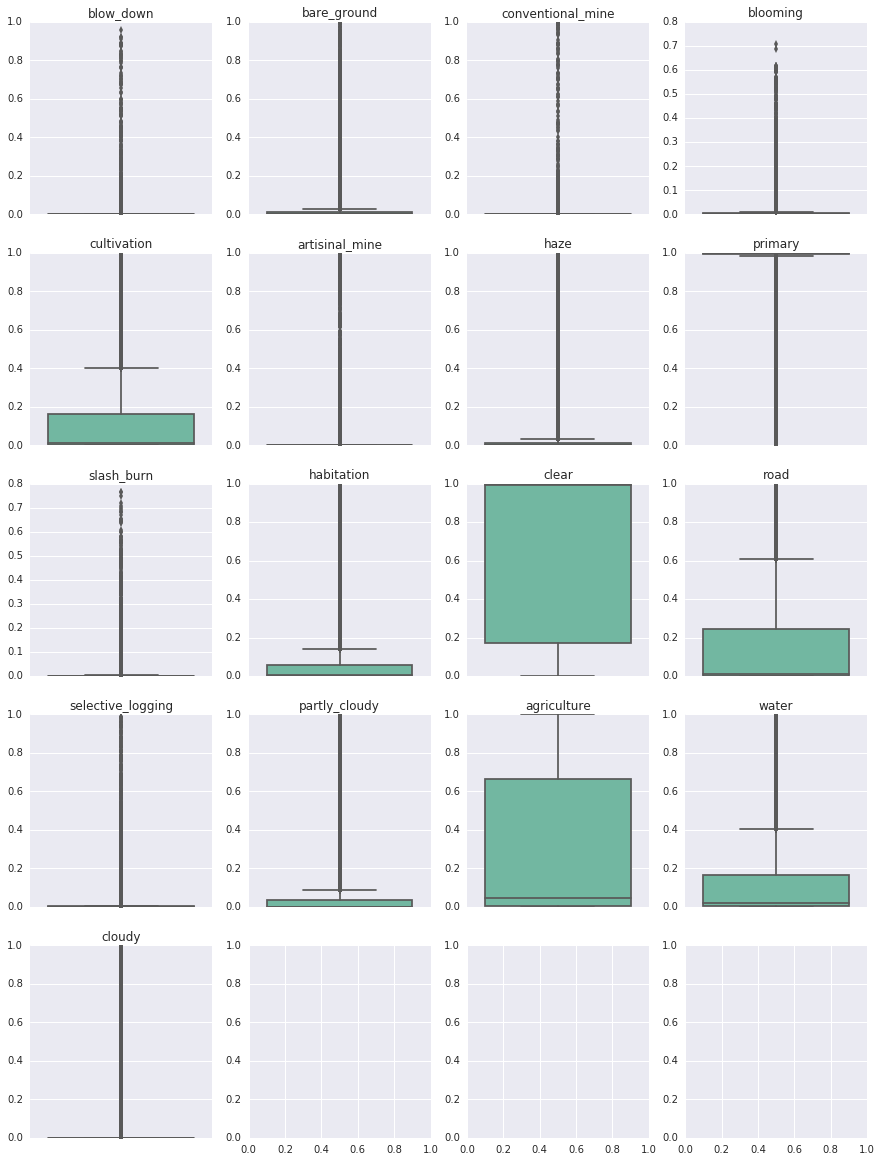

In [25]:
import seaborn as sns
tags_pred = np.array(preds).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels[i])


In [26]:
label_preds = []
for i in tqdm_notebook(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    label_preds.append(' '.join(list(a.index)))

In [27]:
df_test["tags"] = label_preds
df_test.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy


In [28]:
df_test.head(100)

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy
5,test_5,primary clear
6,test_6,cultivation primary habitation clear partly_cl...
7,test_7,primary habitation clear road
8,test_8,primary clear
9,test_9,cultivation haze primary clear agriculture


In [64]:
df_test.head(100)

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,cultivation primary clear agriculture
4,test_4,primary partly_cloudy
5,test_5,primary clear
6,test_6,cultivation haze primary habitation partly_clo...
7,test_7,primary habitation clear road agriculture
8,test_8,primary clear
9,test_9,cultivation haze primary agriculture


In [33]:
submission_file = 'subm/resnet_full_224x224_blend_2resnets.csv'
df_test.to_csv(submission_file, index=False)
FileLink(submission_file)

/home/ubuntu/planet/subm/resnet_full_224x224_blend_2resnets.csv